In [5]:
import qiskit as qk
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import transpile
from qiskit.visualization import plot_histogram
from math import pi
from qiskit import *
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2, SamplerV2
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService
import pandas as pd
import numpy as np
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from time import time
from qiskit.circuit.library.standard_gates import RYGate, RYYGate

# from keras.models import Sequential
# from keras.layers import Dense, Activation
# from keras.datasets import mnist
# from sklearn.metrics import mean_squared_error, mean_absolute_error, mutual_info_score, r2_score
# from qiskit.circuit.library.standard_gates import RYGate, RYYGate
# import cv2

In [6]:
def hadamard(circ, n):
  for i in n:
    circ.h(i)

In [7]:
# This function let us know which are the qubits that need to be applied  
# the X-gate so we can change the state of the pixels positions qubits
# to the new state.
def change(state, new_state):
  n = len(state)  # n is the length of the binary string
  c = np.array([])  # create an empty array
  for i in range(n):  # start to iterate n times
    if state[i] != new_state[i]:  # here we check if the position i in the 
                                  # binary string is different
      c = np.append(c, int(i))

  if len(c) > 0:
    return c.astype(int)
  else:
    return c

In [8]:
# This function applies the X-gates to the corresponding qubits given by 
# the change function
def binary(circ, state, new_state):
  # state is the string in binary format that tells us the actual state of the pixels
  # state = '000000'
  c = change(state, new_state)
  if len(c) > 0:
    # Modified section. Added the -1 and the np.abs
    circ.x(np.abs(c-5))
  else: 
    pass

In [9]:
# This function applies the C^n(Ry) (controlled Ry gate) in the quantum circuit
# "circ" using the vector "n" for the controlled qubits and the variable "t" for
# the target qubit, and "theta" for the angle in the rotation. 
def cnri(circ, n, t, theta):
  #rq = circuit.qubits
  controls = len(n)
  cry = RYGate(2*theta).control(controls)
  aux = np.append(n, t).tolist()
  circ.append(cry, aux)

In [10]:
# The frqi function calls all of the aleady defined function to fully implement
# The FRQI method over the quantum circuit "circ", with the vector of controlled
# qubits "n", the target qubit "t" and the angles of each pixel in the image.
def frqi(circ,n ,t, angles):
  hadamard(circ, n)
  j = 0
  for i in angles:
    state = '{0:06b}'.format(j-1)
    new_state = '{0:06b}'.format(j)
    if j == 0:
      cnri(circ, n, t, i)
    else:
      binary(circ, state, new_state)
      cnri(circ, n, t, i)
    j += 1

Text(0.5, 1.0, 'Original Image')

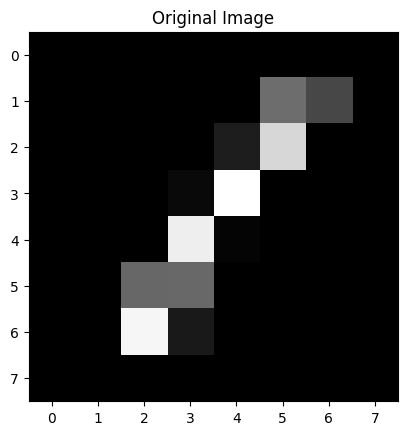

In [11]:
dataset = pd.read_csv('mnist_dataset.csv')
images = dataset.to_numpy()[:,1:].reshape(42000,8,8)
pixel_values = images.reshape(42000,64)

selected_index = 0

plt.imshow(images[selected_index,:], cmap='gray')
normalized_pixels = pixel_values/255.0
angles = np.arcsin(normalized_pixels[selected_index,:])
plt.title("Original Image")



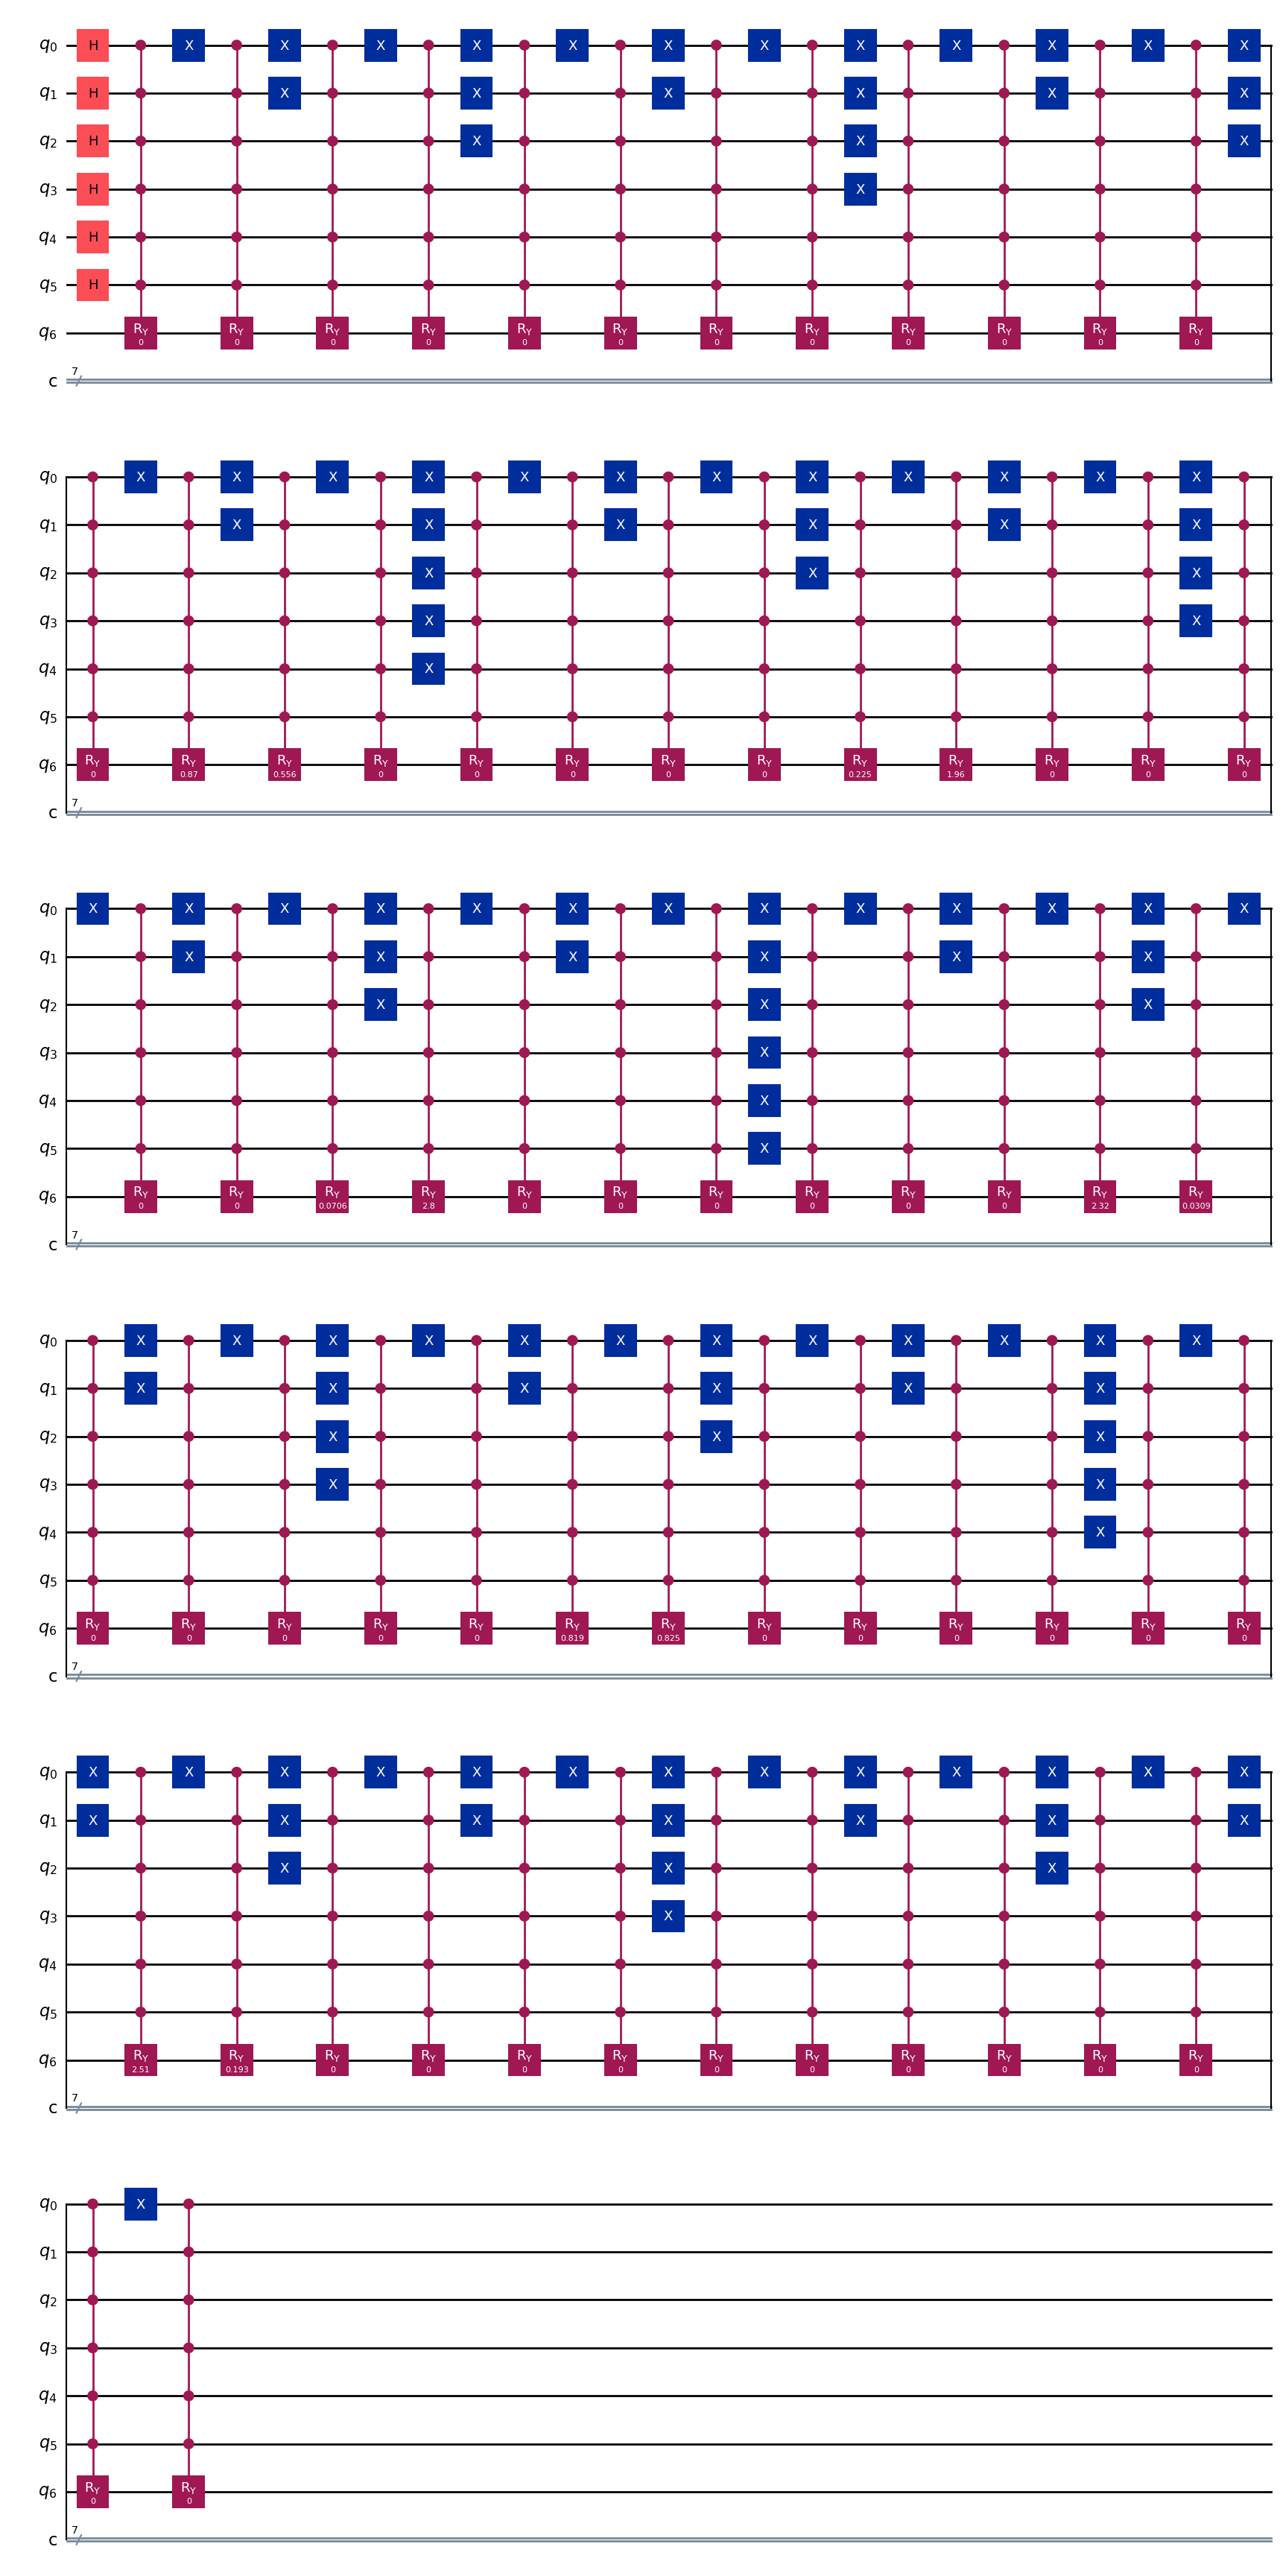

In [12]:
# Declare the Quantum and Classical registers
qr = QuantumRegister(7,'q')
cr = ClassicalRegister(7,'c')
qc = QuantumCircuit(qr,cr)
frqi(qc, [0,1,2,3,4,5], 6, angles)
qc.draw('mpl')


In [13]:
qc.measure([0,1,2,3,4,5,6],[0,1,2,3,4,5,6])

In [14]:

from qiskit import transpile
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
simulator = AerSimulator()

# Transpile the circuit for the simulator
t_qc = transpile(qc, simulator)

# Run the circuit on the simulator
num_shots = 64
result = simulator.run(t_qc, shots=num_shots).result()

# Get the counts (measurement outcomes)
counts = result.get_counts()

# Simplify the keys in the counts dictionary
simplified_counts = {key.split()[0]: value for key, value in counts.items()}

# Print the simplified counts
print("Simplified counts:", simplified_counts)

Simplified counts: {'0001101': 1, '0100100': 1, '0100000': 1, '0000111': 2, '0111100': 1, '0101111': 1, '0110110': 2, '0100010': 1, '0011111': 1, '0101000': 1, '0010010': 3, '0000001': 1, '0011010': 1, '0011011': 2, '0101101': 1, '1100011': 2, '0100001': 1, '0011001': 1, '0010000': 1, '0011000': 1, '1011100': 1, '0110111': 1, '0010011': 1, '0010101': 1, '1010101': 1, '0001001': 1, '0110000': 1, '0101010': 2, '0110100': 2, '0111010': 2, '0010001': 2, '0101011': 3, '0111011': 2, '0100101': 4, '0001000': 2, '0011101': 1, '0000110': 2, '0110101': 1, '0100111': 1, '0111101': 1, '0001011': 2, '0101100': 1, '0000011': 1, '0101001': 2}


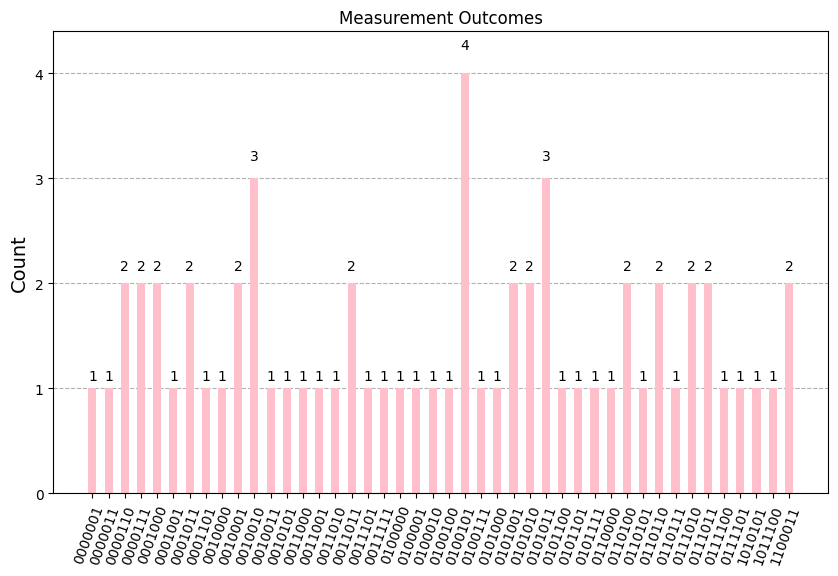

In [15]:
# Plot the histogram of results
fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure and axes
plot_histogram(simplified_counts, title="Measurement Outcomes", bar_labels=True, ax=ax, color="pink")  # Pass the axes to plot_histogram
plt.show()

In [16]:

# Create an empty array to save the retrieved image
retrieve_image = np.array([])

In [17]:
# We iterate over all the pixels and obtain the proability results for each one of them
# Notice that we compute the ratio of the white states, and only if the values are 0
# we make an exception and turn that pixel 0
# for i in range(64):
#   try:
#     s = format(i, '06b')
#     new_s = '1' + s
#     retrieve_image = np.append(retrieve_image,np.sqrt(simplified_counts[new_s]/num_shots))
    
#   except KeyError:
#     retrieve_image = np.append(retrieve_image,[0.0])


for i in range(64):
    s = format(i, '06b')
    new_s = '1' + s
    try:
        value = np.sqrt(simplified_counts[new_s] / num_shots)
    except KeyError:
        value = 0.0  # Default value if the key is not found
    retrieve_image = np.append(retrieve_image, value)  # Append only once
    
    

In [18]:
# We make the inverse nomalization
retrieve_image *=  8.0*255.0

In [19]:
# Turn the array into a type int
retrieve_image = retrieve_image.astype('int')

In [20]:
print("Size of retrieve_image after loop:", retrieve_image.size)

Size of retrieve_image after loop: 64


In [21]:
# Reshape the array into a 8x8 matrix
retrieve_image = retrieve_image.reshape((8,8))

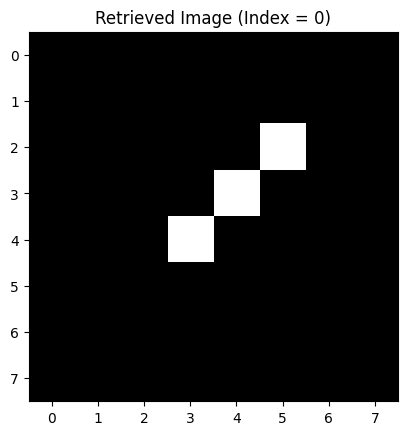

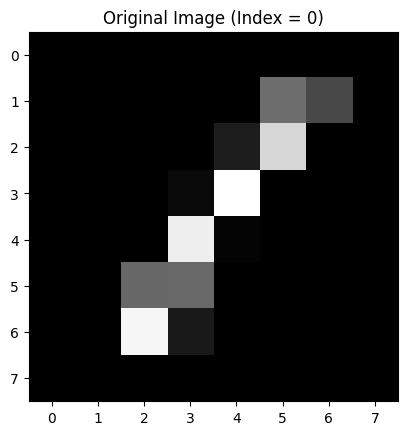

In [22]:
# Plot the retrieved image to see if it is the same as the one encoded
plt.imshow(retrieve_image, cmap='gray', vmin=0, vmax=255)
plt.title(f"Retrieved Image (Index = {selected_index})")
plt.show()

plt.imshow(images[selected_index,:], cmap='gray')
plt.title(f"Original Image (Index = {selected_index})")
plt.show()

In [23]:
from qiskit.quantum_info import Statevector, state_fidelity

# normalize the original image and convert to quantum state
original_image_flat = images[selected_index, :].flatten()
original_image_normalized = original_image_flat / np.linalg.norm(original_image_flat)

# normalize the retrieved image and convert to quantum state
retrieved_image_flat = retrieve_image.flatten()
retrieved_image_normalized = retrieved_image_flat / np.linalg.norm(retrieved_image_flat)

# fidelity calculation
original_state = Statevector(original_image_normalized)
retrieved_state = Statevector(retrieved_image_normalized)

fidelity = state_fidelity(original_state, retrieved_state)

print(f"Fidelity between the original and retrieved images: {fidelity}")

Fidelity between the original and retrieved images: 0.6058946667500748


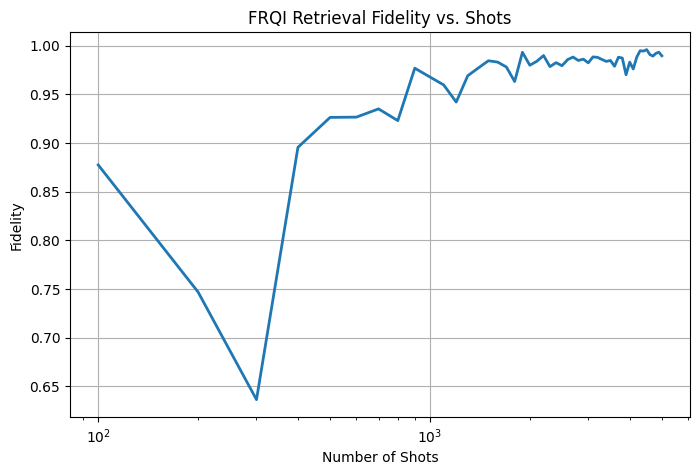

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector, state_fidelity

# Prepare the “ideal” FRQI state (no measurements) once:
orig_flat = images[selected_index].flatten()
orig_norm = orig_flat / np.linalg.norm(orig_flat)
ideal_state = Statevector(orig_norm)

# Define the range of shots to test
shot_counts = np.linspace(100, 5000, 50, dtype=int)
fidelities = []

for shots in shot_counts:
    # Run your circuit with measurements for this many shots
    result = simulator.run(t_qc, shots=shots).result()
    counts = result.get_counts()

    # Reconstruct the retrieved image exactly as in your notebook:
    retrieved = np.zeros_like(orig_flat, dtype=float)
    for idx in range(64):
        key = '1' + format(idx, '06b')   # measurement key for a “white” FRQI pixel
        freq = counts.get(key, 0)
        retrieved[idx] = np.sqrt(freq / shots) if freq else 0.0
    # inverse normalization from FRQI
    retrieved = (retrieved * 8.0 * 255.0).astype(int)
    retr_norm = retrieved / np.linalg.norm(retrieved)

    # compute fidelity
    fidelities.append(state_fidelity(ideal_state, Statevector(retr_norm)))

# Plot shots vs fidelity
plt.figure(figsize=(8,5))
plot = plt.plot(shot_counts, fidelities, '-', lw=2)
plt.xscale('log')
plt.xlabel('Number of Shots')
plt.ylabel('Fidelity')
plt.title('FRQI Retrieval Fidelity vs. Shots')
plt.grid(True)
plt.show()
